In [1]:
import os
import email
import re
import mailparser
import random
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from bs4 import BeautifulSoup
from tld import get_tld
from time import strftime, strptime, time
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, recall_score
from itertools import product
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC 
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

Set constants for directories, take a random sampling of the "ignore" email since there are so many (under sample)

In [2]:
IGNORE_DIR = '/Users/worshamn/Documents/emailProject/IgnoreFix'
INVESTIGATE_DIR = '/Users/worshamn/Documents/emailProject/InvestigateFix'
#https://stackoverflow.com/a/6482922
random.seed(4948)
ignore_sample_index = [ i for i in sorted(random.sample(range(len(os.listdir(IGNORE_DIR))), 400)) ]
ignore_sample = []
for i in ignore_sample_index:
    ignore_sample.append(os.listdir(IGNORE_DIR)[i])
input_dirs = {}
input_dirs[INVESTIGATE_DIR] = os.listdir(INVESTIGATE_DIR) 
input_dirs[IGNORE_DIR] = ignore_sample

In [3]:
ignore_sample

['[Phish Alert] FW- 9 Signs You’re Successful—Even If It Doesn’t Feel Like It.eml',
...
 '[Phish Alert] FW- Professional Web Design  Services...eml']

len(input_dirs)

In [4]:
len(input_dirs[INVESTIGATE_DIR])

384

In [5]:
len(input_dirs[IGNORE_DIR])

400

Build function to extract text and features

In [6]:
def get_email_text(file):
    d = {}
    raw_message = email.message_from_file(file)
    mail = mailparser.parse_from_string(raw_message.as_string())
    d['subject'] = mail.subject
    d['subject_len'] = len(d['subject'])
    if raw_message.is_multipart():
        d['is_mulitpart'] = 1
    else:
        d['is_multipart'] = 0
    d['body'] = mail.text_plain
    if len(d['body']) > 0:
        d['mail_text'] = d['subject'] + ' ' + d['body'][0]
        d['body_len'] = len(d['body'][0])
        if len(d['body']) > 1:
            soup_html = BeautifulSoup(d['body'][1],'lxml')
            d['links'] = soup_html.find_all('a')
            d['num_link'] = len(d['links'])
            links = []
            d['masq_link'] = []
            d['masq_link_tld'] = []
            d['num_email_link'] = 0
            for link in d['links']:
                link_text = link.get_text().rstrip('\n')
                a_link = link.get('href')
                links.append(a_link)
                if 'unsubscribe' in link_text.lower():
                    d['has_unsubscribe_link'] = 1
                if a_link:    
                    if re.search('mailto:',a_link):
                        d['num_email_link'] += 1
                if a_link != link_text and \
                    'http' in link_text.lower() and \
                    not 'alt="http' in link_text.lower():
                        d['masq_link'].append(link)
                        d['masq_link_tld'].append(
                            get_tld(
                                a_link,
                                fix_protocol=True, 
                                fail_silently=True
                            )
                        )
            d['num_uniq_link'] = len(set(links))
            if d['num_link'] > d['num_uniq_link']:
                d['has_repeatlink'] = 1
            else:
                d['has_repeatlink'] = 0
            if len(d['masq_link']) == 0:
                d['masq_link'] = ''
                d['masq_link_tld'] = ''
                d['has_masq_link'] = 0
            else:    
                d['has_masq_link'] = 1
                d['num_masq_link'] = len(d['masq_link'])
    else:
        d['mail_text'] = d['subject']
        d['body_len'] = len(d['body'])
    url_query = '((?:https?|ftp)://[^\s/$.?#]+\.[^\s>]+)'
    d['url'] = re.findall(url_query,d['mail_text'])
    email_query = '([\w.]+@[\w.]+\.[\w.]{2,5})'
    d['email'] = re.findall(email_query,d['mail_text'])
    if d['url']:
        d['has_url'] = 1
        d['num_url'] = len(d['url'])
        d['num_uniq_url'] = len(set(d['url']))
        d['num_url_repeats'] = d['num_url'] - d['num_uniq_url']
        d['url_len'] = []
        d['url_tld'] = []
        for i in d['url']:
            d['url_len'].append(len(i))
            d['url_tld'].append(
                get_tld(i, fix_protocol=True, fail_silently=True)
            )
            d['uniq_url_tld'] = set(d['url_tld'])
    else:
        d['url'] = ''
        d['has_url'] = 0
        d['num_url'] = 0
        d['num_uniq_url'] = 0
        d['url_len'] = 0
        d['url_tld'] = 0
        d['uniq_url_tld'] = 0
        d['num_url_repeats'] = 0
    if d['email']:
        d['has_email'] = 1
        d['num_email_addr'] = len(d['email'])
        d['num_uniq_email'] = len(set(d['email']))
    else:
        d['email'] = ''
        d['has_email'] = 0
        d['num_email_addr'] = 0
        d['num_uniq_email'] = 0
    soup = BeautifulSoup(d['mail_text'],'lxml')
    try:
        d['mail_text'] = soup.get_text().encode(
            'utf-8',
            'ignore'
        ).decode('unicode_escape').replace('\n',' ').replace('\t',' ')
    except:
        d['mail_text'] = soup.get_text().replace('\n',' ').replace('\t',' ')
    d['reply_to'] = mail.reply_to
    for k,v in mail.headers.items():
        d[k] = v
    d['body'] = mail.body
    d['text_plain'] = mail.text_plain
    if mail.attachments:
        d['has_attachments'] = 1
        d['num_attachments'] = len(mail.attachments)
        for i in mail.attachments:
            try:
                d['attachment_filename'].append(i['filename'])
            except:
                d['attachment_filename'] = []
                d['attachment_filename'].append(i['filename'])
            try:
                d['attachment_content_type'].append(i['mail_content_type'])
            except:
                d['attachment_content_type'] = []
                d['attachment_content_type'].append(i['mail_content_type'])
    else:
        d['has_attachments'] = 0
    if re.search(tryGetKeyValue(d, 'Return-Path'),tryGetKeyValue(d, 'From')):
        d['return_path_match_from'] = 1
    else:
        d['return_path_match_from'] = 0
    tld_match = re.match(
            '[^@]+@([^>]+)>',
            tryGetKeyValue(d, 'From')
        )
    if tld_match:
        d['from_tld'] = get_tld(
            tld_match.group(1),
            fix_protocol=True, 
            fail_silently=True
        )
    if 'content="text/html' in d['body'].lower():
        d['has_html_content'] = 1
    else:
        d['has_html_content'] = 0
    if 'script type="text/javascript' in d['body'].lower():
        d['has_javascript'] = 1
    else:
        d['has_javascript'] = 0
    if 'img src="cid:' in d['body'].lower():
        d['has_inline_img'] = 1
    else:
        d['has_inline_img'] = 0
    if 'Content-type' in d:
        d['Content-type'] = re.match('([^;]+);',d['Content-type']).group(1)
    else:
        d['Content-type'] = None
    if 'Date' in d:
        #d['DOTW'] = strftime('%a',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['DOTW'] = strftime('%w',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
        d['HOTD'] = strftime('%H',strptime(d['Date'],'%a, %d %b %Y %H:%M:%S %z'))
    if mail.has_defects:
        d['has_defects'] = 1
    else:
        d['has_defects'] = 0
    return d

Build function to set the target value based on the directory

In [7]:
def get_target(d):
    if d == IGNORE_DIR:
        return 'ignore'
    elif d == INVESTIGATE_DIR:
        return 'investigate'

Build function to extract value only if the key exists

In [8]:
def tryGetKeyValue(d, key, return_value=''):
  """Attempts to return value of key from dictionary
  """
  try:
    return d[key]
  except:
    return return_value

Create dataframe, iterate through directories and add email features

In [9]:
df = pd.DataFrame()
for d,v in input_dirs.items():
    for f in input_dirs[d]:
        print(d, f)
        with open(os.path.join(d,f),'r',encoding='utf-8', errors='ignore') as raw_mail:
            mail_dict = get_email_text(raw_mail)
            df = df.append(
                {
                    #'filename': f,
                    'text': mail_dict['mail_text'],
                    'target': get_target(d),
                    'subject_len': mail_dict['subject_len'],
                    'body_len': mail_dict['body_len'],
                    'has_attachments': tryGetKeyValue(mail_dict, 'has_attachments',0),
                    'num_attachments': tryGetKeyValue(mail_dict, 'num_attachments',0),
                    #'attachment_filename': tryGetKeyValue(mail_dict, 'attachment_filename'),
                    #'attachment_content_type': tryGetKeyValue(mail_dict, 'attachment_content_type'),
                    'DKIM': tryGetKeyValue(mail_dict, 'X-BAEAI-DKIM'),
                    'DMARC': tryGetKeyValue(mail_dict, 'X-BAEAI-DMARC'),
                    'SPF': tryGetKeyValue(mail_dict, 'X-BAEAI-SPF'),
                    'return_path_match_from': mail_dict['return_path_match_from'],
                    'from_tld': tryGetKeyValue(mail_dict, 'from_tld'),
                    'Content-type': mail_dict['Content-type'],
                    'DOTW': tryGetKeyValue(mail_dict, 'DOTW'),
                    'HOTD': tryGetKeyValue(mail_dict, 'HOTD'),
                    #'url': mail_dict['url'],
                    'has_url': tryGetKeyValue(mail_dict, 'has_url',0),
                    'num_url': tryGetKeyValue(mail_dict, 'num_url',0),
                    'num_uniq_url': tryGetKeyValue(mail_dict, 'num_uniq_url',0),
                    #'email': tryGetKeyValue(mail_dict, 'email'),
                    'has_email': tryGetKeyValue(mail_dict, 'has_email',0),
                    'num_email_addr': tryGetKeyValue(mail_dict, 'num_email_addr',0),
                    'num_uniq_email': tryGetKeyValue(mail_dict, 'num_uniq_email',0),
                    'num_url_repeats': tryGetKeyValue(mail_dict, 'num_url_repeats',0),
                    #'url_len': mail_dict['url_len'],
                    #'url_tld': mail_dict['url_tld'],
                    #'uniq_url_tld': mail_dict['uniq_url_tld'],
                    'has_html_content': tryGetKeyValue(mail_dict, 'has_html_content',0),
                    'has_javascript': tryGetKeyValue(mail_dict, 'has_javascript',0),
                    'has_inline_img': tryGetKeyValue(mail_dict, 'has_inline_img',0),
                    'TAP-Score': tryGetKeyValue(mail_dict, 'X-USANET-TAP-Score',-1),
                    #'links': tryGetKeyValue(mail_dict, 'links'),
                    'num_link': tryGetKeyValue(mail_dict, 'num_link',0),
                    'num_uniq_link': tryGetKeyValue(mail_dict, 'num_uniq_link',0),
                    'has_repeat_link': tryGetKeyValue(mail_dict, 'has_repeat_link',0),
                    #'masq_link': tryGetKeyValue(mail_dict, 'masq_link'),
                    'has_masq_link': tryGetKeyValue(mail_dict, 'has_masq_link',0),
                    'num_masq_link': tryGetKeyValue(mail_dict, 'num_masq_link',0),
                    #'masq_link_tld': tryGetKeyValue(mail_dict, 'masq_link_tld'),
                    'is_multipart': tryGetKeyValue(mail_dict, 'is_mulitpart', 0),
                    'has_defects': mail_dict['has_defects'],
                    'num_email_link': tryGetKeyValue(mail_dict, 'num_email_link',0),
                    'has_unsubscribe_link': tryGetKeyValue(mail_dict, 'has_unsubscribe_link', 0),
                }, 
                ignore_index=True
            )

/Users/worshamn/Documents/emailProject/InvestigateFix [Phish Alert] FW- Goodchem Document.eml
...
/Users/worshamn/Documents/emailProject/IgnoreFix [Phish Alert] FW- Professional Web Design  Services...eml


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 34 columns):
Content-type              773 non-null object
DKIM                      784 non-null object
DMARC                     784 non-null object
DOTW                      784 non-null object
HOTD                      784 non-null object
SPF                       784 non-null object
TAP-Score                 784 non-null object
body_len                  784 non-null float64
from_tld                  784 non-null object
has_attachments           784 non-null float64
has_defects               784 non-null float64
has_email                 784 non-null float64
has_html_content          784 non-null float64
has_inline_img            784 non-null float64
has_javascript            784 non-null float64
has_masq_link             784 non-null float64
has_repeat_link           784 non-null float64
has_unsubscribe_link      784 non-null float64
has_url                   784 non-null float64
is_multipa

Create a function to clean the text

In [11]:
def clean_text(
    docs, 
    remove_urls=True,
    remove_emails=True,
    lemmatize=True,
    remove_stopwords=True, 
    custom_stopwords=None,
#     term_min_len=0,
):
    #only use parts of spaCy needed
    nlp = spacy.load('en', disable=['parser','ner','textcat'])
    #remove urls
    if remove_urls:
        print('remove URLS')
        docs = [
            re.sub('(?i)(?:www|https?)(?:://)?[^\s]+','',text)
            for text in docs
        ]
    #remove emails
    if remove_emails:
        print('remove email addresses')
        docs = [
            re.sub('(?i)[\w.]+@[\w.]+\.[\w.]{2,5}','',text)
            for text in docs
        ]
    #remove punct and digits
    print('removing punctuation and digits and change to lowercase')
    table = str.maketrans({key: None for key in string.punctuation + string.digits})
    clean_docs = [
        str(d).lower().translate(table)
        for d in docs
    ]
        
    #tokenize in spacy
    if lemmatize:
        print('spacy tokenization')
        nlp_docs = [nlp(d) for d in clean_docs]
        #lemmatization, words like I get changed into -PRON- so leave them alone
        if remove_stopwords:
            print('lemmatization and remove stopwords')
            if custom_stopwords:
                custom_stopwords = set(custom_stopwords)
            else:
                custom_stopwords = []
            lemmatized_docs = [
                [
                    w.lemma_ 
                    for w in d
                    if (w.lemma_ != '-PRON-' and not w.is_stop and w.lemma_ not in custom_stopwords) 
                ]
                for d in nlp_docs
            ]
        else:
            print('lemmatization')
            lemmatized_docs = [
            [
                w.lemma_
                if w.lemma_ != '-PRON-'
                else w.lower_
                for w in d
                #if (w.lemma_ != '-PRON-' and len(w.lemma_)>term_min_len)
            ]
            for d in nlp_docs
        ]
    if lemmatized_docs:
        clean_docs = lemmatized_docs
    
    # join tokens back into doc
    clean_docs = [
        ' '.join(l) 
        for l in clean_docs
    ]

    return clean_docs

Clean the text

In [12]:
t0 = time()
corpus = clean_text(
    df['text'], 
)
print("done in %0.3fs" % (time() - t0))

remove URLS
remove email addresses
removing punctuation and digits and change to lowercase
spacy tokenization
lemmatization and remove stopwords
done in 9.183s


In [13]:
df['cleaned_text'] = pd.Series(corpus).values

Convert cells that are not recognized as a number or just to get rid of float

In [14]:
#https://stackoverflow.com/a/28910914
for col in [
    'body_len',
    'has_attachments',
    'has_defects',
    'has_email',
    'has_html_content',
    'has_inline_img',
    'has_javascript',
    'has_masq_link',
    'has_repeat_link',
    'has_unsubscribe_link',
    'has_url',
    'is_multipart',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_link',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
    'return_path_match_from',
    'subject_len',
    #'TAP-Score',
]:
    df[col] = df[col].astype(int)
    

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 35 columns):
Content-type              773 non-null object
DKIM                      784 non-null object
DMARC                     784 non-null object
DOTW                      784 non-null object
HOTD                      784 non-null object
SPF                       784 non-null object
TAP-Score                 784 non-null object
body_len                  784 non-null int64
from_tld                  784 non-null object
has_attachments           784 non-null int64
has_defects               784 non-null int64
has_email                 784 non-null int64
has_html_content          784 non-null int64
has_inline_img            784 non-null int64
has_javascript            784 non-null int64
has_masq_link             784 non-null int64
has_repeat_link           784 non-null int64
has_unsubscribe_link      784 non-null int64
has_url                   784 non-null int64
is_multipart              784 no

Break the continous data into ranges for binary conversion

In [16]:
#https://stackoverflow.com/a/40548606
df['body_len'] = pd.qcut(df['body_len'],20,duplicates='drop')
df['subject_len'] = pd.qcut(df['subject_len'],10,duplicates='drop')
df['num_attachments'] = pd.cut(df['num_attachments'],5)
df['num_email_addr'] = pd.cut(df['num_email_addr'],5)
df['num_email_link'] = pd.cut(df['num_email_link'],5)
df['num_link'] = pd.qcut(df['num_link'],10,duplicates='drop')
df['num_masq_link'] = pd.cut(df['num_masq_link'],3)
df['num_uniq_email'] = pd.qcut(df['num_uniq_email'],10,duplicates='drop')
df['num_uniq_url'] = pd.qcut(df['num_uniq_url'],10,duplicates='drop')
df['num_url'] = pd.qcut(df['num_url'],10,duplicates='drop')
df['num_url_repeats'] = pd.qcut(df['num_url_repeats'],10,duplicates='drop')

Change the continuous and categorical data into one-hot encoding (binary data)

In [17]:
categorical_cols = [
    'DKIM',
    'DMARC',
    'SPF',
    'from_tld',
    'Content-type',
    'DOTW',
    'HOTD',
    'TAP-Score',
    'body_len',
    'subject_len',
    'num_attachments',
    'num_email_addr',
    'num_email_link',
    'num_link',
    'num_masq_link',
    'num_uniq_email',
    'num_uniq_url',
    'num_url',
    'num_url_repeats',
]

In [18]:
df_categorical = pd.get_dummies(df[categorical_cols])

In [19]:
df.drop(categorical_cols, axis=1, inplace=True)

In [20]:
df = pd.concat([df,df_categorical], axis=1)

In [21]:
pd.set_option('display.max_colwidth', 40)

In [22]:
df.head()

,has_attachments,has_defects,has_email,has_html_content,has_inline_img,has_javascript,has_masq_link,has_repeat_link,has_unsubscribe_link,has_url,...,"num_url_(-0.001, 1.0]","num_url_(1.0, 2.0]","num_url_(2.0, 4.0]","num_url_(4.0, 6.0]","num_url_(6.0, 10.0]","num_url_(10.0, 17.0]","num_url_(17.0, 247.0]","num_url_repeats_(-0.001, 1.0]","num_url_repeats_(1.0, 2.0]","num_url_repeats_(2.0, 101.0]"
0,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0


In [23]:
for i in df.columns:
    print(i)

has_attachments
has_defects
has_email
has_html_content
has_inline_img
has_javascript
has_masq_link
has_repeat_link
has_unsubscribe_link
has_url
is_multipart
num_uniq_link
return_path_match_from
target
text
cleaned_text
DKIM_
DKIM_FAIL
DKIM_NONE
DKIM_PASS
DMARC_
DMARC_absent
DMARC_none
DMARC_pass
DMARC_quarantine
DMARC_reject
SPF_
SPF_ERROR
SPF_NEUTRAL
SPF_NONE
SPF_PASS
SPF_SOFTFAIL
from_tld_
from_tld_ai
from_tld_bg
from_tld_biz
from_tld_ca
from_tld_ch
from_tld_club
from_tld_co
from_tld_co.jp
from_tld_co.uk
from_tld_co.za
from_tld_com
from_tld_com.ar
from_tld_com.br
from_tld_com.do
from_tld_com.ec
from_tld_com.mx
from_tld_com.my
from_tld_com.pk
from_tld_de
from_tld_edu
from_tld_email
from_tld_es
from_tld_eu
from_tld_fi
from_tld_fr
from_tld_global
from_tld_gob.cl
from_tld_gob.ec
from_tld_gov
from_tld_gr
from_tld_hu
from_tld_ie
from_tld_info
from_tld_io
from_tld_it
from_tld_k12.in.us
from_tld_k12.wi.us
from_tld_media
from_tld_mx
from_tld_ne.jp
from_tld_net
from_tld_net.pl
from_tld_net.tw


Split the sample set into test and training sets

In [24]:
df_target = df['target']
df_feats = df.drop(['target','text'],axis=1)
train_feats, test_feats, train_labels, test_labels = train_test_split(
    df_feats, 
    df_target, 
    test_size=0.20, 
    random_state=7350
)

In [25]:
train_feats.shape

(627, 201)

In [26]:
test_feats.shape

(157, 201)

In [27]:
train_labels.value_counts()

ignore         318
investigate    309
Name: target, dtype: int64

#### TFIDF Creation

In [28]:
t0 = time()
vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    #max_df=0.9, 
    min_df=2,
    use_idf=False,
    binary=True,
)
train_feats_text = vectorizer.fit_transform(train_feats['cleaned_text'].values.tolist())
test_feats_text = vectorizer.transform(test_feats['cleaned_text'].values.tolist()) 
print("done in %0.3fs" % (time() - t0))

done in 0.560s


In [29]:
train_feats_text.shape

(627, 9797)

In [30]:
test_feats_text.shape

(157, 9797)

Change TFIDF back to dataframe so it can be concatinated with other features

In [31]:
#https://stackoverflow.com/a/50624143
train_feats_text_df = pd.DataFrame(train_feats_text.toarray(), columns=vectorizer.get_feature_names())

In [32]:
train_feats_text_df.head()

,aa,ab,abbuchung,abend,ability,able,able access,able hold,able hold phone,able save,...,zeomega address,zeomega address tennyson,zero,zip,zip code,zoom,zoom discount,zoom discount base,zoom video,zoom video demo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
train_feats = pd.concat([
    train_feats.reset_index(drop=True),
    train_feats_text_df.reset_index(drop=True)
],axis=1)
train_feats.drop('cleaned_text',axis=1,inplace=True)
train_feats.shape

(627, 9997)

Do the same for the test features

In [34]:
test_feats_text_df = pd.DataFrame(test_feats_text.toarray(), columns=vectorizer.get_feature_names())
test_feats_text_df = test_feats_text_df.add_prefix('LSA_')
test_feats = pd.concat([
    test_feats.reset_index(drop=True),
    test_feats_text_df.reset_index(drop=True)
],axis=1)
test_feats.drop('cleaned_text',axis=1,inplace=True)
test_feats.shape

(157, 9997)

Function to keep track of scoring and for printing results out

In [35]:
score_dict = {}
def scoring(score_dict,train_feats,train_labels,test_feats,test_labels,clf):
    if 'accuracy' not in score_dict:
        score_dict['accuracy'] = []
    if 'f1' not in score_dict:
        score_dict['f1'] = []
    if 'recall' not in score_dict:
        score_dict['recall'] = []    
    if 'FN' not in score_dict:
        score_dict['FN'] = []
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    already_seen = clf.score(train_feats, train_labels)
    accuracy = clf.score(test_feats, test_labels)
    pred = clf.predict(test_feats)
    f1 = f1_score(test_labels, pred, pos_label='investigate')
    recall = recall_score(test_labels, pred, pos_label='investigate')
    cnf_matrix = confusion_matrix(test_labels, pred)
    FN = cnf_matrix[1][0]
    false_negative = cnf_matrix[1][0]
    score_dict['accuracy'].append((clf_name,accuracy))
    score_dict['f1'].append((clf_name,f1))
    score_dict['recall'].append((clf_name,recall))
    score_dict['FN'].append((clf_name,false_negative))
    print(clf_name + ' Scores:\n')
    print('Accuracy of data already seen: %0.4f' % already_seen)
    print('Accuracy of data not seen: %0.4f' % accuracy)
    print('F1 score: %0.4f' % f1)
    print('Recall score: %0f' % recall)
    print('False Negatives: %0d' % FN)
    return score_dict

#### Scale the features

In [36]:
min_max_scaler = preprocessing.MinMaxScaler()
train_feats_scaled = min_max_scaler.fit_transform(train_feats)
test_feats_scaled = min_max_scaler.transform(test_feats)

#### SVM

In [37]:
t0 = time()
svm_clf = LinearSVC(random_state=7350,C=0.1,loss='hinge',tol=1e-10)
svm_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats_scaled,train_labels,test_feats_scaled,test_labels,svm_clf)

done in 0.134s
LinearSVC Scores:

Accuracy of data already seen: 0.9936
Accuracy of data not seen: 0.9363
F1 score: 0.9367
Recall score: 0.986667
False Negatives: 1


#### Extra Trees Classifier

In [38]:
t0 = time()
et_clf = ExtraTreesClassifier(
    n_jobs=-1,
    n_estimators=100,
    random_state=7350,
    max_leaf_nodes=200,
    max_depth=50,
    min_impurity_decrease=0.0001,
)
et_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats_scaled,train_labels,test_feats_scaled,test_labels,et_clf)

done in 0.436s
ExtraTreesClassifier Scores:

Accuracy of data already seen: 0.9856
Accuracy of data not seen: 0.8790
F1 score: 0.8834
Recall score: 0.960000
False Negatives: 3


Get Feature Importances

In [39]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
#https://stackoverflow.com/a/42429989
#https://stackoverflow.com/a/25219535
importances = et_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in et_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = train_feats.columns
print("Feature ranking:")
for f in range(25):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. return_path_match_from (0.035018)
2. num_uniq_url_(-0.001, 1.0] (0.025036)
3. num_url_(-0.001, 1.0] (0.023850)
4. num_link_(-0.001, 1.0] (0.020424)
5. invoice (0.016337)
6. is_multipart (0.014452)
7. SPF_PASS (0.013815)
8. Content-type_Multipart/alternative (0.012532)
9. has_html_content (0.012291)
10. unsubscribe (0.009725)
11. has_unsubscribe_link (0.009017)
12. num_url_(17.0, 247.0] (0.008733)
13. time (0.008545)
14. from_tld_com (0.008069)
15. learn (0.007738)
16. like (0.007656)
17. num_url_(10.0, 17.0] (0.007360)
18. num_uniq_link (0.006539)
19. want (0.006475)
20. SPF_NONE (0.006204)
21. num_link_(14.0, 245.0] (0.006181)
22. Content-type_text/plain (0.005998)
23. num_uniq_url_(9.0, 15.0] (0.005686)
24. num_uniq_url_(5.0, 9.0] (0.005547)
25. num_uniq_url_(15.0, 146.0] (0.005193)


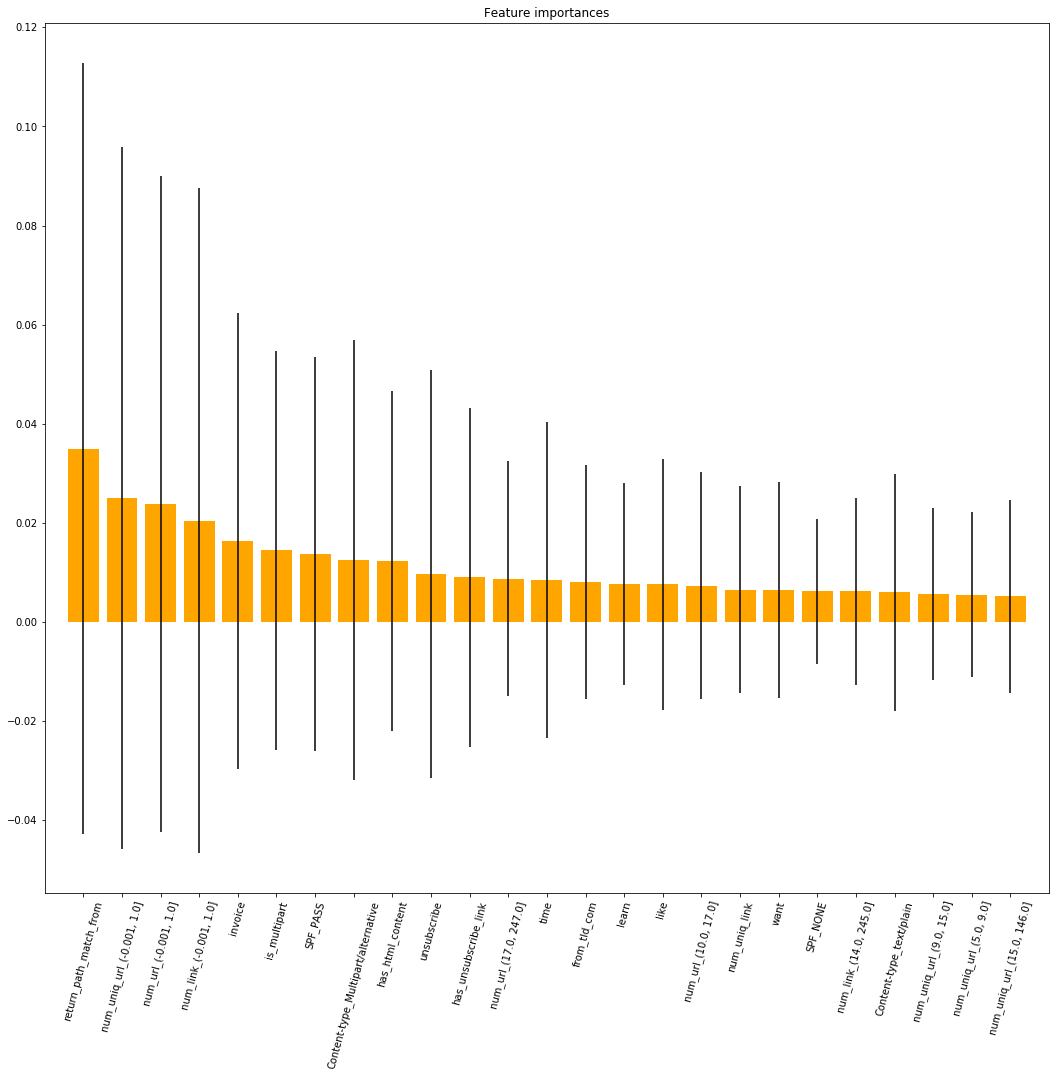

In [40]:
top_indices = indices[:25]
top_features = [features[i] for i in indices[:25]]
plt.figure(figsize=(18, 16))
plt.title("Feature importances")
plt.bar(range(25), importances[top_indices],color="orange", yerr=std[top_indices], align="center",)
plt.xticks(range(25), top_features, rotation=75)
plt.xlim([-1, 25])
plt.show()

#### Neural Net

In [41]:
t0 = time()
nn_clf = MLPClassifier(max_iter=1200,hidden_layer_sizes=(50, 100, 50),learning_rate='adaptive')
nn_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))
score_dict = scoring(score_dict,train_feats_scaled,train_labels,test_feats_scaled,test_labels,nn_clf)

done in 2.135s
MLPClassifier Scores:

Accuracy of data already seen: 0.9952
Accuracy of data not seen: 0.9363
F1 score: 0.9351
Recall score: 0.960000
False Negatives: 3


#### VotingClassifier

In [42]:
t0 = time()
vt_clf = VotingClassifier(estimators=[
    #('knn',knn_clf),
#     ('nb',nb_clf),
    ('et',et_clf),
#     ('rf',rf_clf),
#     ('rd',rd_clf),
    #('bg',bg_clf),
#     ('cc',cc_clf),
    ('svm',svm_clf),
    #('gp',gp_clf),
    #('lr',lr_clf),
#     ('gnb',gnb_clf),
    ('nn',nn_clf),
],voting='hard')
vt_clf.fit(train_feats_scaled, train_labels)
print("done in %0.3fs" % (time() - t0))

done in 3.118s


In [43]:
already_seen = vt_clf.score(train_feats_scaled, train_labels)
accuracy = vt_clf.score(test_feats_scaled, test_labels)
vt_pred = vt_clf.predict(test_feats_scaled)
f1 = f1_score(test_labels, vt_pred, pos_label='investigate')
recall = recall_score(test_labels, vt_pred, pos_label='investigate')
cnf_matrix = confusion_matrix(test_labels, vt_pred)
FN = cnf_matrix[1][0]
false_negative = cnf_matrix[1][0]
print('VotingClassifier Scores:\n')
print('Accuracy of data already seen: %0.4f' % already_seen)
print('Accuracy of data not seen: %0.4f' % accuracy)
print('F1 score: %0.4f' % f1)
print('Recall score: %0.4f' % recall)
print('False Negatives: %0d' % FN)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


VotingClassifier Scores:

Accuracy of data already seen: 0.9936
Accuracy of data not seen: 0.9363
F1 score: 0.9367
Recall score: 0.9867
False Negatives: 1


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Best Classifier Scores

In [44]:
print('Best Accuracy:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['accuracy'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest F1 Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['f1'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)
print('\n\nBest Recall Score:\n')
for i in [
    '%s: %0.4f' % (k,v)
    for k,v in sorted(score_dict['recall'], key=lambda tup: tup[1], reverse=True)
    ][:3]:
    print(i)    
print('\n\nBest False Negative Classifier:\n')
for i in [
    '%s: %i' % (k,v)
    for k,v in sorted(score_dict['FN'], key=lambda tup: tup[1])
    ][:3]:
    print(i)

Best Accuracy:

LinearSVC: 0.9363
MLPClassifier: 0.9363
ExtraTreesClassifier: 0.8790


Best F1 Score:

LinearSVC: 0.9367
MLPClassifier: 0.9351
ExtraTreesClassifier: 0.8834


Best Recall Score:

LinearSVC: 0.9867
ExtraTreesClassifier: 0.9600
MLPClassifier: 0.9600


Best False Negative Classifier:

LinearSVC: 1
ExtraTreesClassifier: 3
MLPClassifier: 3


#### Confusion Matrix and ROC curves of Top Algos

In [45]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
def display_conf_mat(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    pred = clf.predict(test_feats)
    cnf_matrix = confusion_matrix(test_labels, pred)
    np.set_printoptions(precision=2)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['ignore','investigate'],
                          title=clf_name + ' Confusion matrix')
    plt.show()   

In [47]:
#https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/
#https://plot.ly/scikit-learn/plot-roc/
def plot_roc_curve(clf,test_feats,test_labels):
    clf_name = re.findall('(^[^\(]+)\(',str(clf))[0]
    # Binarize the output
    pred = clf.predict(test_feats)
    test_labels_bin = label_binarize(test_labels, classes=['ignore','investigate'])
    pred_bin = label_binarize(pred, classes=['ignore','investigate'])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_labels_bin, pred_bin)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.title(clf_name + ' Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

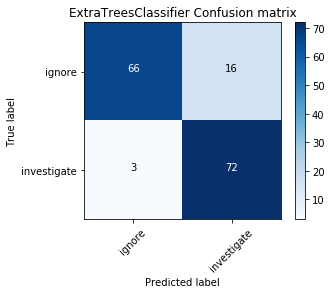

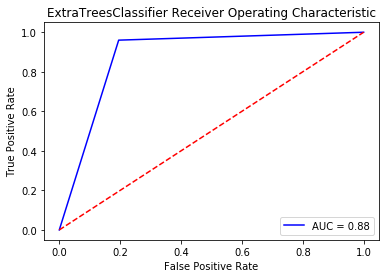

In [48]:
display_conf_mat(et_clf,test_feats_scaled,test_labels)
plot_roc_curve(et_clf,test_feats_scaled,test_labels)

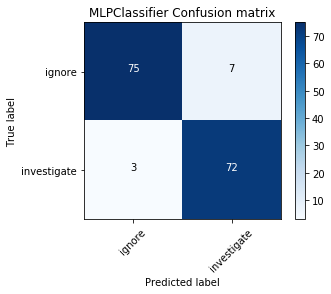

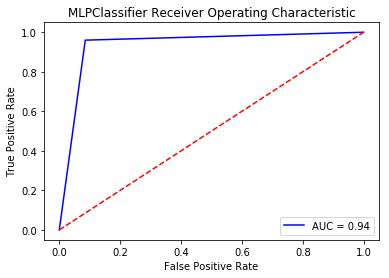

In [49]:
display_conf_mat(nn_clf,test_feats_scaled,test_labels)
plot_roc_curve(nn_clf,test_feats_scaled,test_labels)

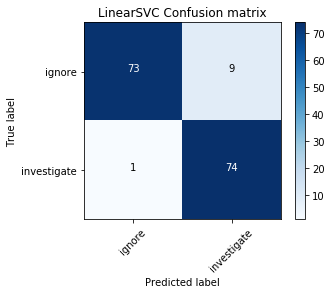

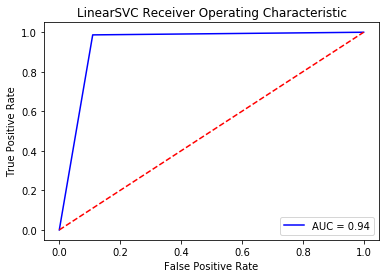

In [50]:
display_conf_mat(svm_clf,test_feats_scaled,test_labels)
plot_roc_curve(svm_clf,test_feats_scaled,test_labels)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


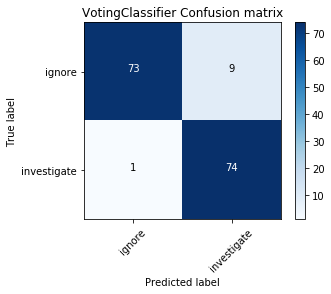

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


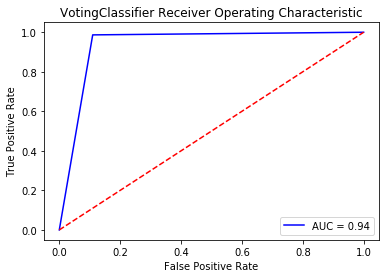

In [51]:
display_conf_mat(vt_clf,test_feats_scaled,test_labels)
plot_roc_curve(vt_clf,test_feats_scaled,test_labels)